In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
model_dir = '/kuacc/users/mali18/dicomogan/logs/__541_fashion_selfattention2022-10-30T03-54-43'
img_root = '/kuacc/users/abond19/datasets/aligned_fashion_dataset'
inverted_img_root =  '/kuacc/users/abond19/datasets/inverted_fashion_dataset'
inversion_root =  '/kuacc/users/abond19/datasets/w+_fashion_dataset/fashion/PTI/'

In [3]:
device = 'cuda'

In [4]:
tgt_desc = [
    "A picture of a woman wearing a Women's blue Regular fit hoodie with a round neckline and Long sleeves"
    
#     'Blue T-shirts Made from rayon-nylon blend Round neckline Slogan printed front Pearl detail Short sleeves Regular fit',
#     'Dresses Shift White One shoulder design Made from cotton Lace detailed ruffled yoke Regular fit Mini length Sleeveless',
#     'Multi Leggings Made from poly-lycra blend Elasticated waistband All over crane print Tape detail at sides Bodycon fit',
#     'a short white Sleeveless Dresses made from cotton',
]

In [5]:
videos = [
    '8c110571',
    '2c111960',
    '8c110147'
]

In [6]:
from experiments_utils import *
model = load_model_from_dir(model_dir).to(device)

Using /scratch/users/mali18/.cache/torch_extensions/py37_cu113 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /scratch/users/mali18/.cache/torch_extensions/py37_cu113/fused/build.ninja...
Building extension module fused...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module fused...
Loading custom kernel...
Using /scratch/users/mali18/.cache/torch_extensions/py37_cu113 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /scratch/users/mali18/.cache/torch_extensions/py37_cu113/upfirdn2d/build.ninja...
Building extension module upfirdn2d...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module upfirdn2d...
Restored from /kuacc/users/mali18/dicomogan/logs/__541_fashion_selfattention2022-10

In [7]:
def save_gif(video, save_path):
    # Assuming that the current shape is T x C x H x W
    import imageio
    with imageio.get_writer(f'{save_path}.gif', mode='I') as writer:
        for img in video:
            writer.append_data(img)

In [23]:
# load images
import os
import torch 
from PIL import Image
import torchvision.transforms as transforms
IMG_EXTENSIONS = ['.png', '.PNG']
TXT_EXTENSIONS = ['.txt']

crop = None
size = None #(256, 192)
trans_list = []
if crop is not None:
    trans_list.append(transforms.CenterCrop(tuple(crop)))
if size is not None:
    trans_list.append(transforms.Resize(tuple(size)))
trans_list.append(transforms.ToTensor())
img_transform=transforms.Compose(trans_list)

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def is_text_file(filename):
    return any(filename.endswith(extension) for extension in TXT_EXTENSIONS)

def get_image(img_path):
    img = Image.open(img_path).convert('RGB')
    return img

def get_inversion(inversion_path):
    w_vector = torch.load(inversion_path, map_location='cpu')
    assert (w_vector.shape == (1, 18, 512)), "Inverted vector has incorrect shape"
    return w_vector

def load_video(vid_path):
    images, inversions, sampleT, inversion_imgs = [], [], [], [] 
    fname = vid_path
    for f in sorted(os.listdir(os.path.join(img_root, fname)))[5:25]:
        if is_image_file(f):
            imname = f[:-4]
            images.append(img_transform(get_image(os.path.join(img_root, fname, f))))
            inversion_imgs.append(img_transform(get_image(os.path.join(inverted_img_root, fname, f))))
            inversions.append(get_inversion(os.path.join(os.path.join(inversion_root, fname, imname + ".pt"))))
            sampleT.append(int(imname))
    
    return torch.stack(images).to(device), torch.cat(inversions, 0).to(device), torch.Tensor(sampleT).to(device), torch.stack(inversion_imgs).to(device)

In [9]:
from torch import nn
def forward_w_color(self, videos, inversions, sampleT, input_desc):
    """
    return a dictionary of tensors in the range [-1, 1]
    """
    ret = dict()

    vid = videos # B x T x ch x H x W -- range [0, 1]
    input_desc = input_desc 
    sampleT = sampleT 
    
    bs, T, ch, height, width = vid.size()
    n_frames = T
    ts = (sampleT)*0.01
    ts = ts - ts[0] 


    video_sample = vid # B x T x C x H x W 
    video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
    video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
    video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

    # inversions reshape
    inversions_bf = inversions # B, T x n_layers x D
    bs, T, n_channels, dim = inversions_bf.shape
    inversions_tf = inversions_bf.permute(1, 0, 2, 3)
    inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

    # downsample res for vae
    vid_rs_full = nn.functional.interpolate(video_sample, scale_factor=0.5, mode="bicubic", align_corners=False, recompute_scale_factor=True)
    vid_rs = vid_rs_full.view(n_frames, bs, ch, int(height*0.5),int(width*0.5) )
    vid_rs = vid_rs.permute(1,0,2,3,4) #  B x T x C x H//2 x W//2

    # encode text
    txt_feat = self.clip_encode_text(input_desc)  # B x D
    txt_feat = txt_feat.unsqueeze(0).repeat(n_frames,1,1)
    txt_feat = txt_feat.view(bs * n_frames, -1)  # T*B x D

    # vae encode frames
    zs, zd, mu_logvar_s, mu_logvar_d = self.bVAE_enc(vid_rs, ts)
    z_vid = torch.cat((zs, zd), 1) # T*B x D 

    muT, logvarT = self.text_enc(txt_feat)
    zT = self.reparametrize(muT, logvarT) # T*B x D 

    # generate with mathching text
    latentw = self.mapping(z_vid[:,self.vae_cond_dim:])
    
    frame_rep = torch.cat((latentw, txt_feat), -1) # T*B x D1+D2

    # predict latents delta
    w_latents = inversions + self.delta_inversion_weight * self.style_mapper(inversions, frame_rep)
    ret = self.stylegan_G(w_latents) / 2 + 0.5 
    ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
    return ret



In [10]:
from torch import nn
def forward_from_mean(self, videos, inversions, sampleT, input_desc):
    """
    return a dictionary of tensors in the range [-1, 1]
    """
    ret = dict()

    vid = videos # B x T x ch x H x W -- range [0, 1]
    input_desc = input_desc 
    sampleT = sampleT 
    
    bs, T, ch, height, width = vid.size()
    n_frames = T
    ts = (sampleT)*0.01
    ts = ts - ts[0] 


    video_sample = vid # B x T x C x H x W 
    video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
    video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
    video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

    # inversions reshape
    inversions_bf = inversions # B, T x n_layers x D
    bs, T, n_channels, dim = inversions_bf.shape
    inversions_tf = inversions_bf.permute(1, 0, 2, 3)
    inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

    # downsample res for vae
    vid_rs_full = nn.functional.interpolate(video_sample, scale_factor=0.5, mode="bicubic", align_corners=False, recompute_scale_factor=True)
    vid_rs = vid_rs_full.view(n_frames, bs, ch, int(height*0.5),int(width*0.5) )
    vid_rs = vid_rs.permute(1,0,2,3,4) #  B x T x C x H//2 x W//2

    # encode text
    txt_feat = self.clip_encode_text(input_desc)  # B x D
    txt_feat = txt_feat.unsqueeze(0).repeat(n_frames,1,1)
    txt_feat = txt_feat.view(bs * n_frames, -1)  # T*B x D

    # vae encode frames
    zs, zd, mu_logvar_s, mu_logvar_d = self.bVAE_enc(vid_rs, ts)
    z_vid = torch.cat((zs, zd), 1) # T*B x D 

    muT, logvarT = self.text_enc(txt_feat)
    zT = self.reparametrize(muT, logvarT) # T*B x D 

    # generate with mathching text
    latentw = self.mapping(z_vid[:,self.vae_cond_dim:])

    frame_rep = torch.cat((latentw, txt_feat), -1) # T*B x D1+D2

    # predict latents delta
    src_inversion = inversions_tf.mean(0, keepdims=True) # 1 x B x 18 x 512
    src_inversion_tf = src_inversion.repeat(T, 1, 1, 1)
    src_inversion = src_inversion_tf.reshape(T*bs, n_channels, dim)
    w_latents = src_inversion + self.delta_inversion_weight * self.style_mapper(src_inversion, frame_rep)
    ret = self.stylegan_G(w_latents) / 2 + 0.5 
    ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
    return ret



In [11]:
from torch import nn
def tmp_forward(self, videos, inversions, sampleT, input_desc):
    """
    return a dictionary of tensors in the range [-1, 1]
    """
    ret = dict()

    vid = videos # B x T x ch x H x W -- range [0, 1]
    input_desc = input_desc 
    sampleT = sampleT 
    
    bs, T, ch, height, width = vid.size()
    n_frames = T
    ts = (sampleT)*0.01
    ts = ts - ts[0] 


    video_sample = vid # B x T x C x H x W 
    video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
    video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
    video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

    # inversions reshape
    inversions_bf = inversions # B, T x n_layers x D
    bs, T, n_channels, dim = inversions_bf.shape
    inversions_tf = inversions_bf.permute(1, 0, 2, 3)
    inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

    # downsample res for vae
    vid_rs_full = nn.functional.interpolate(video_sample, scale_factor=0.5, mode="bicubic", align_corners=False, recompute_scale_factor=True)
    vid_rs = vid_rs_full.view(n_frames, bs, ch, int(height*0.5),int(width*0.5) )
    vid_rs = vid_rs.permute(1,0,2,3,4) #  B x T x C x H//2 x W//2

    # encode text
    txt_feat = self.clip_encode_text(input_desc)  # B x D
    txt_feat = txt_feat.unsqueeze(0).repeat(n_frames,1,1)
    txt_feat = txt_feat.view(bs * n_frames, -1)  # T*B x D

    # vae encode frames
    zs, zd, mu_logvar_s, mu_logvar_d = self.bVAE_enc(vid_rs, ts)
    
    # swap dynamics
    zd = zd.view(T, bs, -1).contiguous()
    zd = torch.roll(zd, 1, 1)
    zd = zd.view(T*bs, -1).contiguous()
    
    
    z_vid = torch.cat((zs, zd), 1) # T*B x D 

    muT, logvarT = self.text_enc(txt_feat)
    zT = self.reparametrize(muT, logvarT) # T*B x D 

    # generate with mathching text
    latentw = self.mapping(z_vid[:,self.vae_cond_dim:])

    frame_rep = (latentw, txt_feat) # T*B x D1+D2

    # predict latents delta
    src_inversion = inversions_tf.mean(0, keepdims=True) # 1 x B x 18 x 512
#     src_inversion = inversions_tf[-1:]# 1 x B x 18 x 512
    src_inversion_tf = src_inversion.repeat(T, 1, 1, 1)
#     src_inversion_tf = inversions_tf
    src_inversion = src_inversion_tf.reshape(T*bs, n_channels, dim)
    w_latents = src_inversion + self.delta_inversion_weight * self.style_mapper(src_inversion, *frame_rep)
    ret = self.stylegan_G(w_latents) / 2 + 0.5 
    ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
    return ret


In [12]:
def forward_hairclip(self, videos, inversions, sampleT, input_desc):
    """
    return a dictionary of tensors in the range [-1, 1]
    """
    ret = dict()

    vid = videos # B x T x ch x H x W -- range [0, 1]
    input_desc = input_desc 
    sampleT = sampleT 

    bs, T, ch, height, width = vid.size()
    n_frames = T
    ts = (sampleT)*0.01
    ts = ts - ts[0] 


    video_sample = vid # B x T x C x H x W 
    video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
    video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
    video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

    # inversions reshape
    inversions_bf = inversions # B, T x n_layers x D
    bs, T, n_channels, dim = inversions_bf.shape
    inversions_tf = inversions_bf.permute(1, 0, 2, 3)
    inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

    txt_feat = self.get_text_embedding(input_desc) # B x D
    txt_feat = txt_feat.unsqueeze(0).repeat(n_frames, 1, 1) # T x B x D
    txt_feat = txt_feat.view(bs * n_frames, -1) # T * B x D

    adjusted_latent = inversions + self.delta_inversion_weight * self.mapping_network(inversions, txt_feat)

    ret = self.G(adjusted_latent) / 2 + 0.5 
    ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
    return ret


In [13]:
def forward_hairclip_same_dir(self, videos, inversions, sampleT, input_desc):
    """
    return a dictionary of tensors in the range [-1, 1]
    """
    ret = dict()

    vid = videos # B x T x ch x H x W -- range [0, 1]
    input_desc = input_desc 
    sampleT = sampleT 

    bs, T, ch, height, width = vid.size()
    n_frames = T
    ts = (sampleT)*0.01
    ts = ts - ts[0] 


    video_sample = vid # B x T x C x H x W 
    video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
    video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
    video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

    # inversions reshape
    inversions_bf = inversions # B, T x n_layers x D
    bs, T, n_channels, dim = inversions_bf.shape
    inversions_tf = inversions_bf.permute(1, 0, 2, 3)
    inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

    txt_feat = self.get_text_embedding(input_desc) # B x D
    txt_feat = txt_feat.unsqueeze(0).repeat(n_frames, 1, 1) # T x B x D
    txt_feat = txt_feat.view(bs * n_frames, -1) # T * B x D
    
    deltas = self.delta_inversion_weight * self.mapping_network(inversions, txt_feat) # T * B x n_layers x D
    deltas = deltas.reshape(T, bs, n_channels, dim)[0:1]
    deltas = deltas.repeat(T, 1, 1, 1).reshape(T * bs, n_channels, dim)
    adjusted_latent = inversions + deltas

    ret = self.G(adjusted_latent) / 2 + 0.5 
    ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
    return ret

In [14]:
def forward_triple(self, videos, inversions, sampleT, input_desc):
        """
        return a dictionary of tensors in the range [-1, 1]
        """
        vid = videos # B x T x ch x H x W -- range [0, 1]
        input_desc = input_desc 
        sampleT = sampleT 
        
        bs, T, ch, height, width = vid.size()
        n_frames = T
        ts = (sampleT) / model.video_length
        ts = ts - ts[0] 


        video_sample = vid # B x T x C x H x W 
        video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
        video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
        video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

        # inversions reshape
        inversions_bf = inversions # B, T x n_layers x D
        bs, T, n_channels, dim = inversions_bf.shape
        inversions_tf = inversions_bf.permute(1, 0, 2, 3)
        inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

        # downsample res for vae
        vid_rs_full = nn.functional.interpolate(video_sample, scale_factor=0.5, mode="bicubic", align_corners=False, recompute_scale_factor=True)
        vid_rs = vid_rs_full.view(n_frames, bs, ch, int(height*0.5),int(width*0.5) )
        vid_rs = vid_rs.permute(1,0,2,3,4) #  B x T x C x H//2 x W//2

        # encode text
        txt_feat = self.clip_encode_text(input_desc)  # B x D
        txt_feat = txt_feat.unsqueeze(0).repeat(n_frames,1,1)
        txt_feat = txt_feat.view(bs * n_frames, -1)  # T*B x D

        # vae encode frames
        zs, zd, mu_logvar_s, mu_logvar_d = self.bVAE_enc(vid_rs, ts)
        z_vid = torch.cat((zs, zd), 1) # T*B x D 
        video_style = zs[:, :self.vae_cond_dim]
        video_content = zs[:, self.vae_cond_dim:]
        video_dynamics = zd
#         print("video_dynamics", video_dynamics[0])

        muT, logvarT = self.text_enc(txt_feat)
        zT = self.reparametrize(muT, logvarT) # T*B x D 
        text_video_style = zT
        

        # roll batch-wise
        
        # frame_rep = (latentw, video_style) # T*B x D1+D2
        # frame_rep_txt_mismatched = (latentw, text_video_style_mismatch) # T*B x D1+D2
        
        # frame rep (video_style, video_content, dynamics)
#         print(video_content[0].norm())
#         print(video_content[1].norm())
#         print((video_content[0]-video_content[1]).abs().norm())
#         video_dynamics = torch.roll(video_dynamics, 1, dims=0)
#         video_content = torch.zeros_like(video_content)
#         video_content = torch.roll(video_content, 1, dims=0)
        
        frame_rep = (txt_feat, video_content, video_dynamics) # T*B x D1+D2
#         print(video_dynamics.shape)

        # predict latents delta
        src_inversion = inversions_tf.mean(0, keepdims=True) # 1 x B x 18 x 512
        src_inversion_tf = src_inversion.repeat(T, 1, 1, 1)
#         src_inversion_tf = torch.cat([inversions_tf[:, :, :4, :], src_inversion_tf[:, :, 4:, :]], -2)
        src_inversion = src_inversion_tf.reshape(T*bs, n_channels, dim)
        w_latents = src_inversion + self.delta_inversion_weight * self.style_mapper(src_inversion, *frame_rep)
        
        ret = self.stylegan_G(w_latents) / 2 + 0.5 
        ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
        return ret

In [18]:
tgt_desc

["A picture of a woman wearing a Women's blue Regular fit hoodie with a round neckline and Long sleeves"]

In [210]:
videos= ['8c110571']

In [213]:
from tqdm import tqdm
with torch.no_grad():
    for video in tqdm(videos):
        images, inversions, sampleT, inversion_imgs = load_video(video)
        
        save_dir = os.path.join('results', f"{model_dir.split('/')[-1]}", video)
        os.makedirs(save_dir, exist_ok=True)
        # org
        save_gif(images.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/original')
        
        # inversion
        save_gif(inversion_imgs.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/inversion')
        
        for j, des in enumerate(tgt_desc):
#         images = images.unsqueeze(0).repeat(ln_desc, 1, 1, 1, 1)
#         inversions = inversions.unsqueeze(0).repeat(ln_desc, 1, 1, 1)
            edited_videos = forward_triple(model, images.unsqueeze(0), inversions.unsqueeze(0), sampleT, [des])[0]
            print(edited_videos.shape)
            save_gif(edited_videos.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/desc_{j}')
        
        
        

  0%|          | 0/1 [00:00<?, ?it/s]Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conve

torch.Size([20, 3, 1024, 512])


Lossy conversion from float32 to uint8. Range [0.16039049625396729, 1.0172755718231201]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.1536237895488739, 1.0171914100646973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.14984819293022156, 1.0171129703521729]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.14430087804794312, 1.0171256065368652]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.1377962827682495, 1.0170934200286865]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.1349097192287445, 1.0170562267303467]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.13601773977279663, 1.017055273

In [131]:
videos = [
'2c112948',
'8c109258',
'8c110569'
]

In [130]:
tgt_desc = [
    "A picture of a woman wearing a Women's pink t-shirt with v-neckline and short sleeves and blue skirt", 
    "A picture of a woman wearing a Women's black sleeveless t-shirt with v-neckline and blue jeans"
    
#     'Blue T-shirts Made from rayon-nylon blend Round neckline Slogan printed front Pearl detail Short sleeves Regular fit',
#     'Dresses Shift White One shoulder design Made from cotton Lace detailed ruffled yoke Regular fit Mini length Sleeveless',
#     'Multi Leggings Made from poly-lycra blend Elasticated waistband All over crane print Tape detail at sides Bodycon fit',
#     'a short white Sleeveless Dresses made from cotton',
]

In [179]:
# swape the dynamics
from tqdm import tqdm
with torch.no_grad():
    for j, des in enumerate(tgt_desc):
        a_images, a_inv, a_sampleT = [], [], []
        for video in tqdm(videos):
            images, inversions, sampleT, inversion_imgs = load_video(video)
            save_dir = os.path.join('results', f"{model_dir.split('/')[-1]}_content_swapped", video)
            os.makedirs(save_dir, exist_ok=True)
            # org
#             save_gif(images.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/original')

            # inversion
#             save_gif(inversion_imgs.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/inversion')
            
            a_images.append(images)
            a_inv.append(inversions)
            a_sampleT.append(sampleT)

        

#         images = images.unsqueeze(0).repeat(ln_desc, 1, 1, 1, 1)
#         inversions = inversions.unsqueeze(0).repeat(ln_desc, 1, 1, 1)
        edited_videos = forward_triple(model, torch.stack(a_images), torch.stack(a_inv), sampleT, [des] * len(videos))
        
        for edited_video, video in zip(edited_videos, videos):
            save_dir = os.path.join('results', f"{model_dir.split('/')[-1]}_content_swapped", video)
            save_gif(edited_video.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/desc_{j}')
        

100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


tensor(4.4682, device='cuda:0')
tensor(4.9661, device='cuda:0')
tensor(6.5171, device='cuda:0')


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


tensor(4.1265, device='cuda:0')
tensor(5.3004, device='cuda:0')
tensor(6.5789, device='cuda:0')


In [24]:
images, inversions, sampleT, inversion_imgs = load_video('9c112557')

In [25]:
mean_inv = inversions.mean(0, keepdims=True)

In [17]:
des = tgt_desc[-1]
with torch.no_grad():
    ws, edited_videos = forward_triple(model, images.unsqueeze(0), inversions.unsqueeze(0), sampleT, [des])


TypeError: forward() missing 1 required positional argument: 'mask'

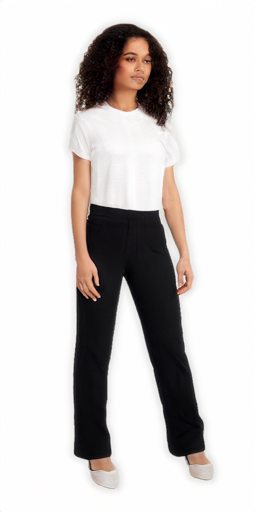

In [34]:
a_inv = inversions[4:5] + 0.05 * torch.rand_like(inversions[4:5])
with torch.no_grad():
    a = model.stylegan_G(a_inv)[0]
to_PIL(a).resize((128*2, 256*2))

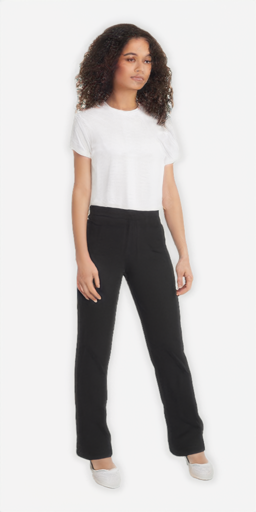

In [27]:
to_PIL(inversion_imgs[4] * 2 - 1).resize((128*2, 256*2))

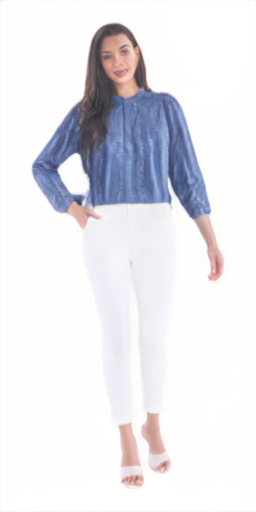

In [166]:
b_inv = ws[15:16]
with torch.no_grad():
    b = model.stylegan_G(b_inv)[0]
to_PIL(b).resize((128*2, 256*2))

In [167]:
# des = tgt_desc[-1]
# with torch.no_grad():
#     ws, edited_videos = forward_triple(model, images.unsqueeze(0), inversions.unsqueeze(0), sampleT, [des])


In [168]:
import torch.nn as nn
l2_latent_loss = nn.MSELoss()

In [178]:
l2_latent_loss(a_inv[0, l:r], b_inv[0,l:r])

tensor(0.0015, device='cuda:0')

In [170]:
diff = a_inv[0, 6:8] - b_inv[0, 6:8]
diff.abs().sum(-1)

tensor([26.6970, 19.9226], device='cuda:0')

In [218]:
l, r = 0, 2
tgt_w = a_inv.clone()
tgt_w[0, l:r] = b_inv[0][l:r]
# tgt_w[n-1][m1:m2] = ws[18][n-1][m1:m2]

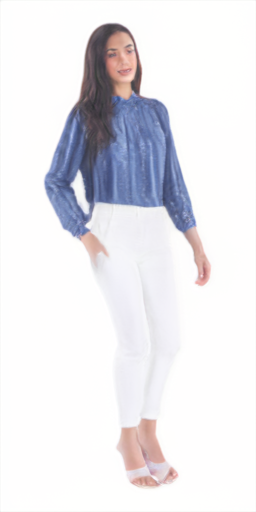

In [219]:
with torch.no_grad():
    c = model.stylegan_G(tgt_w)[0]
to_PIL(c).resize((128*2, 256*2))

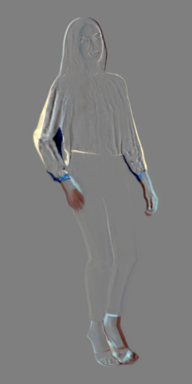

In [220]:
to_PIL(a-c).resize((64*3, 128*3))

In [185]:
from dicomogan.losses.clip_loss import CLIPLoss
clip_loss = CLIPLoss().cuda()

In [186]:
a.shape

torch.Size([3, 1024, 512])

In [194]:
clip_loss.consistency_loss(torch.stack((a, b)).unsqueeze(0).cuda())

tensor(0.0353, device='cuda:0')

In [195]:
clip_loss.consistency_loss(torch.stack((c, b)).unsqueeze(0).cuda())

tensor(0.0291, device='cuda:0')

In [202]:
# style, content, dynamic
n = 1

In [209]:
for n in range(4):
    model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_beta.requires_grad = False
    model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_gamma.requires_grad = False
    model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_beta[-1] = 0.9
    model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_gamma[-1] = 0.9

In [203]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_12.blending_gamma

Parameter containing:
tensor([[[0.0143],
         [0.0143],
         [0.0219],
         [0.0168]]], device='cuda:0', requires_grad=True)

In [204]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_12.blending_beta

Parameter containing:
tensor([[[0.0127],
         [0.0147],
         [0.0232],
         [0.0228]]], device='cuda:0', requires_grad=True)

In [205]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_gamma

Parameter containing:
tensor([[[-0.0296],
         [-0.0217],
         [-0.0035],
         [ 0.0135]]], device='cuda:0', requires_grad=True)

In [206]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_beta

Parameter containing:
tensor([[[-0.0310],
         [-0.0204],
         [-0.0019],
         [ 0.0158]]], device='cuda:0', requires_grad=True)

In [80]:
model.style_mapper.fine_mapping.mapper.modulation_module_list[n].combine_modulation.blending_gamma

Parameter containing:
tensor([0.0930], device='cuda:0', requires_grad=True)

In [81]:
model.style_mapper.fine_mapping.mapper.modulation_module_list[n].combine_modulation.blending_beta

Parameter containing:
tensor([0.1266], device='cuda:0', requires_grad=True)

# Generate images for eval 

In [60]:
with open('data/fashion/fashion_train_videos.txt', 'r') as f:
    train_videos = f.read().split('\n')

In [61]:
with open('data/fashion/fashion_test_videos.txt', 'r') as f:
     test_videos = f.read().split('\n')

In [133]:
from tqdm import tqdm
def generate(lst, save_dir, desc, bs=4):
    with torch.no_grad():
        for i in tqdm(range(0, len(lst), bs)):
            images, inversions = [], [],
            for j in range(i, i+bs):
                a, b, c, _ = load_video(lst[j])
                images.append(a)
                inversions.append(b)
                sampleT = c
            
#             print(torch.stack(images, 0).shape, torch.stack(inversions, 0).shape)
            edited_videos = forward_triple(model, torch.stack(images, 0), torch.stack(inversions, 0), sampleT, [desc] * bs)          
            for video, video_name in zip(edited_videos, lst[i:i+bs]):
                save_path = os.path.join(save_dir, video_name)
                os.makedirs(save_path, exist_ok=True)
                for j, frame in enumerate(video):
                    to_PIL(frame).save(os.path.join(save_path, f"{j:06d}.png"))

In [134]:
train_save_dir = os.path.join("model_outputs", f"{model_dir.split('/')[-1]}", "train")

In [139]:
test_save_dir = os.path.join("model_outputs", f"{model_dir.split('/')[-1]}", "test")

In [136]:
desc = "A picture of a woman wearing a Women's Black Regular fit Blouse with a Round neckline and Long sleeves and a blue jean"

In [137]:
train_videos = np.array(train_videos)

In [140]:
generate(test_videos[:200], test_save_dir, desc)

100%|██████████| 50/50 [20:35<00:00, 24.72s/it]
